In [1]:
# Deep Learning Libraries
# from tensorflow.compat.v1 import enable_eager_execution
# enable_eager_execution()
from tensorflow import Session
import keras
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, ReLU, GlobalMaxPool1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, Activation, concatenate, SpatialDropout1D, TimeDistributed
from keras.utils import to_categorical
from keras import optimizers, losses, activations, models, initializers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.models import clone_model
# from tensorflow.random import set_random_seed
from keras.layers import AlphaDropout


# XAI Libraries (for LRP)
import innvestigate as inn
import innvestigate.utils
# from vis.visualization import visualize_activation

# Generic ML Libraries
import sklearn
from sklearn.model_selection import GroupShuffleSplit,StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, balanced_accuracy_score, completeness_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from scipy.spatial.distance import cdist
from scipy.stats import kruskal
from scipy.stats import f_oneway

# General Libraries
import numpy as np
from scipy.io import loadmat, savemat
from scipy.fft import fft, fftfreq, ifft
import h5py
import os
from scipy.stats import wasserstein_distance

# Figure Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap

# Statistics Libraries
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.multitest import fdrcorrection

Using TensorFlow backend.


In [2]:
from tensorflow import convert_to_tensor
from tensorflow.math import abs
from sklearn.metrics import accuracy_score

In [3]:
## IMPORT DATA

datadir = "C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Conf_Estimation"
filename = "FBIRN_dFNC_array.mat"

# filename = "COBRE_dFNC_array.mat"

X2 = loadmat(os.path.join(datadir,filename))['data']

X = loadmat(os.path.join(datadir,filename))['data']
Y = np.transpose(loadmat(os.path.join(datadir,filename))['labels']-1)
S = np.transpose(loadmat(os.path.join(datadir,filename))['subject'])

datadir2 = 'C:/Users/antho/Documents/Calhoun_Lab/Projects/Clustering_Explainability/JMLR/KDD2021/DataAndResults/FBIRN_formatted.mat';
groups = loadmat(datadir2)['groups2']
group_names = loadmat(datadir2)['GroupNames2']

print(np.shape(X))
print(np.shape(Y))
print(np.shape(S))
print(np.shape(groups))

(311, 124, 1378)
(311, 1)
(311, 1)
(1378, 1)


In [4]:
# Z-Score Each Feature
mean_val = np.mean(X,axis=(0,1))
std_val = np.std(X,axis=(0,1))
np.shape(std_val)

(1378,)

In [5]:
X = (X - mean_val)/std_val

In [6]:
# Define Model Architecture and Hyperparameters - Model Used for Training
def get_model():
    model = Sequential()
    model.add(Conv1D(16, kernel_size=(4),activation=activations.relu,input_shape=(124,1378)))
    model.add(Conv1D(16, kernel_size=(4),activation=activations.relu,kernel_initializer="he_normal",padding="same"))#,activation=activations.relu))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(rate=0.15))
    
    model.add(Conv1D(24, kernel_size=(4),activation=activations.relu,kernel_initializer="he_normal",padding="same"))
    model.add(Conv1D(24, kernel_size=(4),activation=activations.relu,kernel_initializer="he_normal",padding="same"))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(rate=0.25))
    
    model.add(Conv1D(32, kernel_size=(4),activation=activations.relu,kernel_initializer="he_normal",padding="same"))
    model.add(Conv1D(32, kernel_size=(4),activation=activations.relu,kernel_initializer="he_normal",padding="same"))#,activation=activations.relu))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(rate=0.3))
    model.add(Flatten())
    
    model.add(Dense(18, activation='relu',kernel_initializer="he_normal"))
    model.add(AlphaDropout(rate=0.35))
    model.add(Dense(14, activation='relu',kernel_initializer="he_normal"))
    model.add(AlphaDropout(rate=0.25))
    model.add(Dense(2, activation=activations.softmax))
    opt = optimizers.Adam(0.001)
    
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])

    return(model)

In [7]:
model=get_model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 121, 16)           88208     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 121, 16)           1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60, 16)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 16)            64        
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 24)            1560      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 60, 24)            2328      
__________

In [32]:
# Run Classifier for 10 Folds
n_folds = 10
Y_pred = []; Y_test_all = []; Y_pred_val = []; Y_val_all = [];
val_loss = []; train_loss = [];
val_acc = []; train_acc = []; val_dif = []; val_auc = []; train_auc = [];

count = 0
# split data into Train/Val and Test Groups
cv = StratifiedShuffleSplit(n_splits=n_folds,test_size=0.1,train_size=0.9,random_state=0)#0
for train_val_idx, test_idx in cv.split(X,Y):
    X_train_val = X[train_val_idx,...]
    Y_train_val = Y[train_val_idx,...]
    S_train_val = S[train_val_idx,...]
    X_test = X[test_idx,...]
    Y_test = Y[test_idx,...]
    S_test = S[test_idx,...]

    print(count)
    # Split Train/Val Data into Training and Validation Groups
    cv2 = StratifiedShuffleSplit(n_splits=1,test_size=0.11,train_size=0.89,random_state=0)#0
    for train_idx, val_idx in cv2.split(X_train_val,Y_train_val):
        X_train = X_train_val[train_idx,...]
        Y_train = Y_train_val[train_idx,...]
        S_train = S_train_val[train_idx,...]
        X_val = X_train_val[val_idx,...]
        Y_val = Y_train_val[val_idx,...]
        S_val = S_train_val[val_idx,...]
    X_train_val = []; Y_train_val = []; S_train_val = []
    
    # Define Model Checkpoints

    file_path = "C:/Users/antho/OneDrive/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/cnn_model2_FBIRN_Fold"+str(count)+".hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    %% Create Weights for Model Classes
    values, counts = np.unique(Y_train, return_counts=True)

    weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), np.squeeze(Y_train))
    class_weights = dict(zip(values, weights))
    
    # Define Adaptive Learning Rate
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=15, verbose=2,factor=0.5) #adaptive learning 
    
    # Use Data Augmentation
    np.random.seed(seed=0); val1 = np.random.normal(loc=0,scale=0.7,size=np.shape(X_train)) # set random seed
    np.random.seed(seed=1); val2 = np.random.normal(loc=0,scale=0.5,size=np.shape(X_train)) # set random seed
    np.random.seed(seed=2); val3 = np.random.normal(loc=0,scale=0.2,size=np.shape(X_train)) # set random seed
    X_train = np.concatenate((X_train,X_train+val1,X_train+val2,X_train+val3),axis=0)
    Y_train = np.concatenate((Y_train,Y_train,Y_train,Y_train),axis=0)
    val1 = []; val2 = [];
    
    # Train model
    set_random_seed(count+1) # set seed to increase reproducibility
    model = get_model()
    history = model.fit(X_train, to_categorical(np.array(Y_train)), epochs=75, batch_size=50, shuffle=True, validation_data=(X_val, to_categorical(np.array(Y_val))),callbacks=[checkpoint,redonplat],class_weight=class_weights)
    

    val_loss.append(history.history['val_loss']); train_loss.append(history.history['loss'])
    val_acc.append(history.history['val_acc']); train_acc.append(history.history['acc']);
    
    # Evaluate Model
    
    model = get_model()
    model.load_weights("C:/Users/antho/OneDrive/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/cnn_model2_FBIRN_Fold"+str(count)+".hdf5")
 
    Y_pred.append(np.argmax(model.predict(X_test),axis=1))
    Y_test_all.append(Y_test)
    
#     Y_pred_val.append(np.argmax(model.predict(X_val),axis=1))
#     Y_val_all.append(Y_val)
    
    count += 1

# Save Validation Performance
# dc = {'val_acc':val_acc,'val_loss':val_loss}
# savemat("val_performance.mat",dc)

0
1
2
3
4
5
6
7
8
9


In [27]:
np.max(val_acc,axis=1)

array([0.77419353, 0.80645162, 0.83870965, 0.77419353, 0.83870965,
       0.83870965, 0.87096775, 0.74193549, 0.83870965, 0.87096775])

In [28]:
np.mean(np.max(val_acc,axis=1))

0.8193548262119293

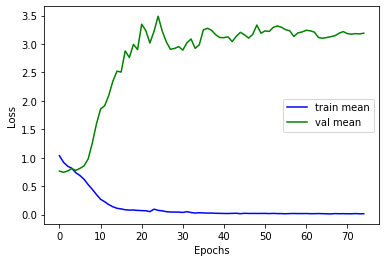

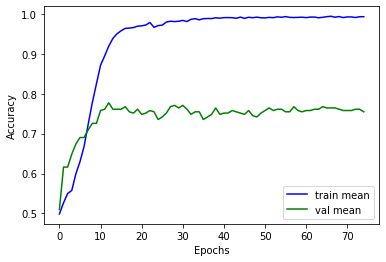

In [30]:
# Plot Mean Training and Validation Performance
plt.plot(np.mean(train_loss,axis=0),'b', label='train mean')
plt.plot(np.mean(val_loss,axis=0),'g', label='val mean')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(np.mean(train_acc,axis=0),'b', label='train mean')
plt.plot(np.mean(val_acc,axis=0),'g', label='val mean')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

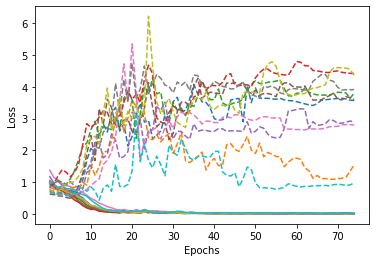

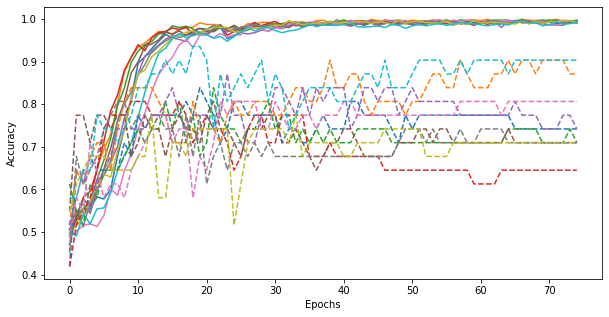

In [31]:
# Plot Model Training and Validation Performance Across Folds
plt.figure()
plt.plot(np.transpose(train_loss), label='train mean')
plt.plot(np.transpose(val_loss),'--', label='val mean')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.transpose(train_acc), label='train mean')
plt.plot(np.transpose(val_acc),'--', label='val mean')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# dashed lines are validation, and solid lines are training

In [29]:
# Unpack Validation Results
Sens = []; Spec = []; Acc = [];
for i in range(n_folds):
    Sens.append(recall_score(np.array(Y_val_all)[i,:], np.array(Y_pred_val)[i,:], pos_label=0))
    Spec.append(recall_score(np.array(Y_val_all)[i,:], np.array(Y_pred_val)[i,:], pos_label=1))
    Acc.append(accuracy_score(np.array(Y_val_all)[i,:], np.array(Y_pred_val)[i,:]))
        

print('Sensitivity')
print(Sens)
print('Specificity')
print(Spec)
print('Accuracy')
print(Acc)

print('Sensitivity')
print(np.mean(Sens))
print(np.std(Sens))
print('Specificity')
print(np.mean(Spec))
print(np.std(Spec))
print('Accuracy')
print(np.mean(Acc))
print(np.std(Acc))

Sensitivity
[0.7333333333333333, 0.8, 1.0, 0.8, 0.8666666666666667, 0.7333333333333333, 0.8, 0.7333333333333333, 0.8, 0.9333333333333333]
Specificity
[0.8125, 0.8125, 0.6875, 0.75, 0.8125, 0.9375, 0.9375, 0.75, 0.875, 0.8125]
Accuracy
[0.7741935483870968, 0.8064516129032258, 0.8387096774193549, 0.7741935483870968, 0.8387096774193549, 0.8387096774193549, 0.8709677419354839, 0.7419354838709677, 0.8387096774193549, 0.8709677419354839]
Sensitivity
0.82
0.08459051693633016
Specificity
0.81875
0.07629097259833564
Accuracy
0.8193548387096774
0.04131047895117968


In [34]:
# Unpack Test Results
Sens = []; Spec = []; Acc = [];
for i in range(n_folds):
    Sens.append(recall_score(np.array(Y_test_all)[i,:], np.array(Y_pred)[i,:], pos_label=0))
    Spec.append(recall_score(np.array(Y_test_all)[i,:], np.array(Y_pred)[i,:], pos_label=1))
    Acc.append(accuracy_score(np.array(Y_test_all)[i,:], np.array(Y_pred)[i,:]))

print('Sensitivity')
print(Sens)
print('Specificity')
print(Spec)
print('Accuracy')
print(Acc)

print('Sensitivity')
print(np.mean(Sens))
print(np.std(Sens))
print('Specificity')
print(np.mean(Spec))
print(np.std(Spec))
print('Accuracy')
print(np.mean(Acc))
print(np.std(Acc))

Sensitivity
[0.8125, 0.8125, 0.6875, 0.625, 0.625, 0.75, 0.9375, 0.8125, 0.6875, 0.9375]
Specificity
[0.8125, 0.75, 1.0, 0.8125, 0.875, 0.8125, 0.8125, 0.75, 0.75, 0.8125]
Accuracy
[0.8125, 0.78125, 0.84375, 0.71875, 0.75, 0.78125, 0.875, 0.78125, 0.71875, 0.875]
Sensitivity
0.76875
0.10843344733060921
Specificity
0.81875
0.07098635432250341
Accuracy
0.79375
0.05448623679425842


## Implement Extracted Feature Subtyping

# Perform LRP Analysis

In [7]:
#LRP Alpha-Beta Rule Implementation
def LRP_Output_ab(model,data,class_labels):
    #Strip softmax layer
    model_lrp = innvestigate.utils.model_wo_softmax(model)

    Rel_out = []
    analyzer = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model_lrp,neuron_selection_mode="index")
    Rel_ep = []
    for j in range(np.shape(data)[0]):
        x = data[j,:,:]
        a = analyzer.analyze(x[None], neuron_selection = class_labels[j])
        # get scaled absolute relevance
        a = np.squeeze(100*np.abs(a)/np.sum(np.abs(a)))[None]
        if j == 0:
            Rel_out = a
        else:
            Rel_out = np.vstack((Rel_out,a))
        
    return(Rel_out)

In [8]:
n_folds = 10
count = 0
train_labels = []; train_subj = []; lrp_valc1 = []; lrp_valc2 = [];
cv = StratifiedShuffleSplit(n_splits=n_folds,test_size=0.1,train_size=0.9,random_state=0)#0
for train_val_idx, test_idx in cv.split(X,Y):
    X_train_val = X[train_val_idx,...]
    Y_train_val = Y[train_val_idx,...]
    S_train_val = S[train_val_idx,...]

    # Split Train/Val Data into Training and Validation Groups
    cv2 = StratifiedShuffleSplit(n_splits=1,test_size=0.11,train_size=0.89,random_state=0)#0
    for train_idx, val_idx in cv2.split(X_train_val,Y_train_val):
        X_train = X_train_val[train_idx,...]
        Y_train = Y_train_val[train_idx,...]
        S_train = S_train_val[train_idx,...]
    X_train_val = []; Y_train_val = []; S_train_val = []
    
    model2 = get_model()
    model2.load_weights("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/cnn_model2_FBIRN_Fold"+str(count)+".hdf5")
    
    train_labels.append(Y_train)
    train_subj.append(S_train)
    lrp_valc2.append(LRP_Output_ab(model2,X_train,Y_train))

    print(count)
    count += 1

train_subj = np.array(train_subj)
train_labels = np.array(train_labels)
lrp_valc2 = np.array(lrp_valc2)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
0
1
2
3
4
5
6


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


7
8
9


In [9]:
# Reshape Data for Averaging
lrp_val2 = []; train_subj2 = []; train_labels2 = []

for i in range(n_folds):
    lrp_val2.extend(lrp_valc2[i,...])
    train_subj2.extend(train_subj[i,...])
    train_labels2.extend(train_labels[i,...])
    
lrp_val2 = np.array(lrp_val2)
train_subj2 = np.array(train_subj2)
train_labels2 = np.array(train_labels2)

In [10]:
# Get Average Relevance for Each Participant Across Folds
lrp_val3 = []; train_subj3 = []; train_labels3 = []; X3 = [];
for i in np.unique(train_subj2): # iterate over participants
    lrp_val3.extend(np.nanmean(lrp_val2[np.squeeze(train_subj2==i*np.ones_like(train_subj2)),:,:],axis=0)) # feature-wise average relevance for participant at iteration i
    train_subj3.extend(i*np.ones((124,)))
    train_labels3.extend(np.unique(train_labels2[np.squeeze(train_subj2==i*np.ones_like(train_subj2))])*np.ones((124,)))
    X3.extend(np.squeeze(X2[np.squeeze(S==i*np.ones_like(S)),:,:]))
    
train_subj3 = np.array(train_subj3)
lrp_val3 = np.array(lrp_val3)
train_labels3 = np.array(train_labels3)
X3 = np.array(X3)

In [11]:
# Normalize Relevance
lrp_val3_unormalized = lrp_val3.copy()
lrp_val3 = (lrp_val3.T/np.sum(lrp_val3,axis=1)).T # divide relevance at each time step by total relevance of the corresponding time step

In [365]:
# Cluster Samples
n_clusters = np.arange(2,11)
silhouette_vals = [];
for i in range(2,11):
    kmeans = KMeans(n_clusters=i,n_init=500,random_state=0).fit(lrp_val3)
    silhouette_vals.append(silhouette_score(lrp_val3,kmeans.labels_))
    
    print(i)

print(silhouette_vals)

2
3
4
5
6
7
8
9
10
[0.008649956, -0.00041364602, 0.0054795854, -0.008851616, -0.010770431, -0.027292717, -0.02775076, -0.029896714, -0.030862818]


Text(0, 0.5, 'Silhouette Score')

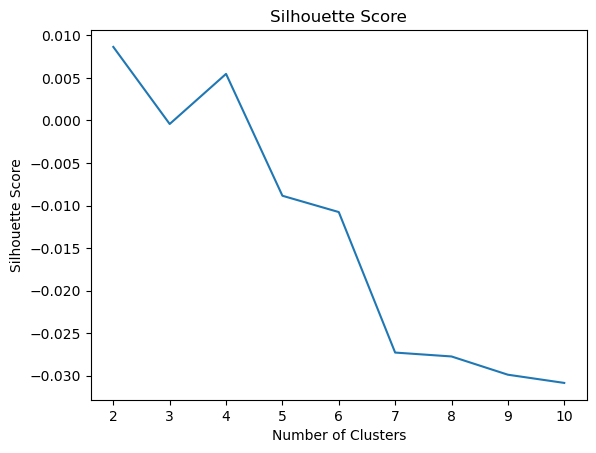

In [9]:
plt.figure()
plt.plot(n_clusters,silhouette_vals)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

In [12]:
top_clust = 4
kmeans = KMeans(n_clusters=top_clust,n_init=500,random_state=0).fit(lrp_val3)
cluster_labels = kmeans.labels_

In [13]:
values, counts = np.unique(kmeans.labels_,return_counts=True)
print(values)
print(counts)

[0 1 2 3]
[ 5422  9978  9373 13791]


# Visualize State Centroids and dFNC in Each State

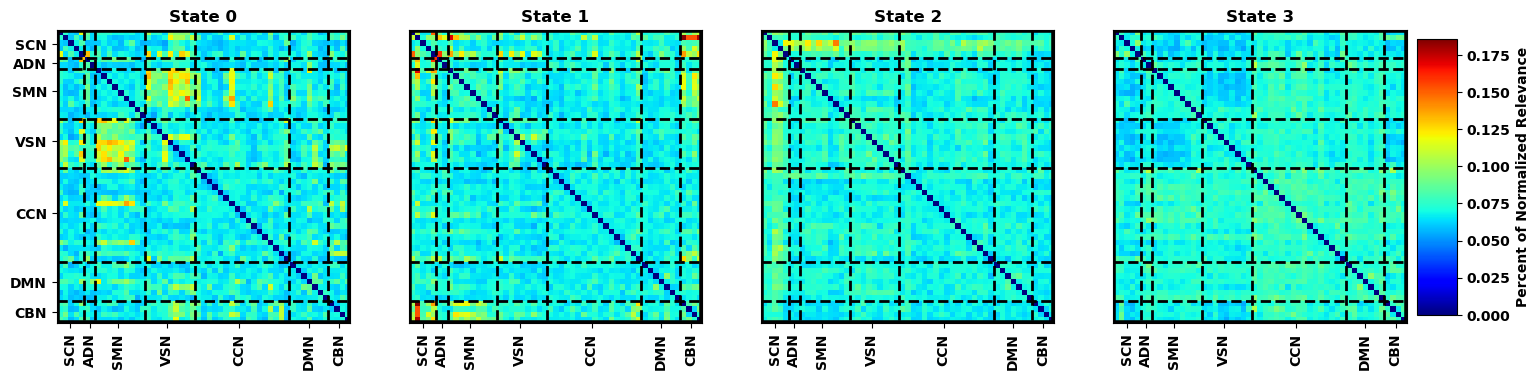

In [16]:
# FIGURE 4

# Scale Centroids Based on Mean and Standard Deviation of Original Z-Scoring
centroids = kmeans.cluster_centers_
max_val = 100*np.max(np.abs(centroids))
networks = ['SCN','ADN','SMN','VSN','CCN','DMN','CBN']
# Make Heatmaps
fig, ax = plt.subplots(1,4,figsize=(20,12))
for i in range(4):
    im = ax[i].imshow(100*vec2mat(centroids[i,:],53), cmap = 'jet', vmin = 0, vmax = max_val)
    ax[i].set_xticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
    ax[i].set_xticklabels(networks,rotation=90,weight='bold')
    ax[i].set_title(f'State {i}',weight='bold')
    if i == 0:
        ax[i].set_yticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
        ax[i].set_yticklabels(networks,weight='bold')
    else:
        ax[i].set_yticks([])
    ax[i].vlines([4.5,6.5,15.5,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=2)
    ax[i].hlines([4.5,6.5,15.5,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=2)
    ax[i].vlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=4)
    ax[i].hlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=4)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.38, 0.02, 0.23]) # left bottom width height
cb = fig.colorbar(im, cax=cbar_ax);
cb.set_label(label='Percent of Normalized Relevance',weight='bold')
plt.setp(cb.ax.get_yticklabels(),weight='bold');
# plt.rcParams["axes.linewidth"] = 1.5
# plt.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/Journal/Results/Figure4 - RelevanceCentroids.jpg",dpi=1200)

Table 2 Information
SZ State 0
0.802
SZ State 1
0.798
SZ State 2
0.545
SZ State 3
0.625
HC State 0
0.664
HC State 1
0.867
HC State 2
0.701
HC State 3
0.676


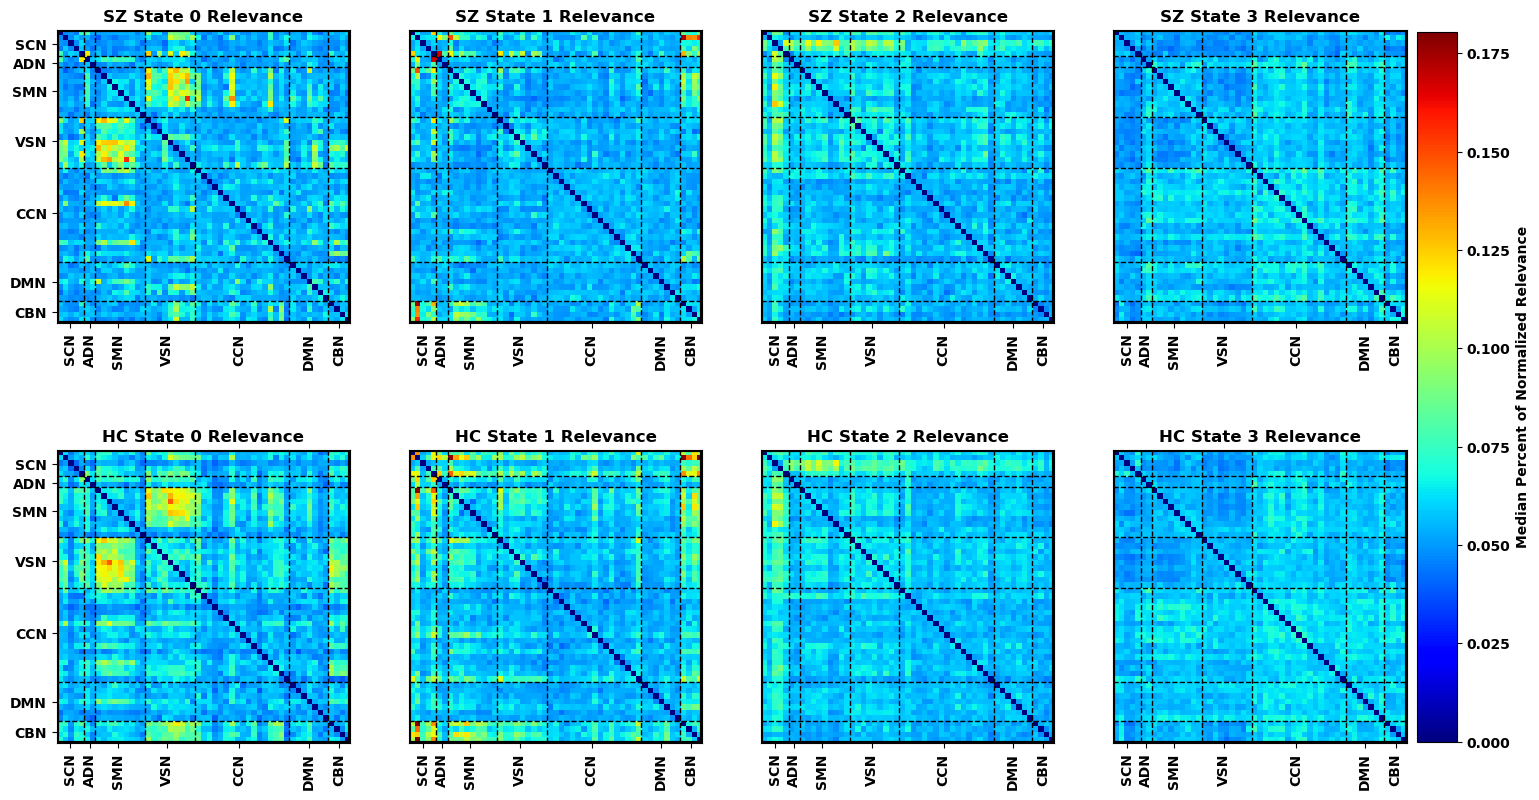

In [28]:
# FIGURE 5
# Make Heatmaps of LRP for Each Cluster
fig, ax = plt.subplots(2,4,figsize=(20,10))
i = 0

print('Table 2 Information')
total_lrp_val3_unormalized = np.sum(lrp_val3_unormalized,axis=1)


# Get Median Relevance Values
s_vals = []
for class_idx in range(2):
    for state in range(4):
        class_condition = train_labels3==class_idx*np.ones_like(train_labels3)
        state_condition = cluster_labels == state*(np.ones_like(cluster_labels))                                        
        s_vals.append(100*np.median(lrp_val3[np.logical_and(class_condition,state_condition),...],axis=0))
        
max_val = np.max(np.abs(s_vals)) # Get Max Heatmap Bounds from Median Relevance Values
min_val = 0
class_val = ['SZ','HC']
for class_idx in range(2):
    for state in range(4):
        class_condition = train_labels3==class_idx*np.ones_like(train_labels3)
        state_condition = cluster_labels == state*(np.ones_like(cluster_labels))   
        median_rel_subgroup = str(np.round(np.median(total_lrp_val3_unormalized[np.squeeze(np.logical_and(class_condition,state_condition))]),decimals=3))
        s_vals = np.median(100*lrp_val3[np.logical_and(class_condition,state_condition),...],axis=0)
        im = ax[class_idx,state].imshow(vec2mat(s_vals,53), cmap = 'jet', vmin = min_val, vmax = max_val)
        ax[class_idx,state].set_xticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
        ax[class_idx,state].set_xticklabels(networks,rotation=90,weight='bold')
        ax[class_idx,state].set_title(f'{class_val[class_idx]} State {state} Relevance',weight='bold') # ({mean_rel_subgroup})
        if state == 0:
            ax[class_idx,state].set_yticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
            ax[class_idx,state].set_yticklabels(networks,weight='bold')
        else:
            ax[class_idx,state].set_yticks([])
        ax[class_idx,state].vlines([4.5,6.5,15.5,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=1)
        ax[class_idx,state].hlines([4.25,6.25,15.25,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=1)
        ax[class_idx,state].vlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=3)
        ax[class_idx,state].hlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=3)
        print(f'{class_val[class_idx]} State {state}')
        print(median_rel_subgroup)
        i += 1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.14, 0.02, 0.71]) # left bottom width height
cb = fig.colorbar(im, cax=cbar_ax);
cb.set_label(label='Median Percent of Normalized Relevance',weight='bold')
plt.setp(cb.ax.get_yticklabels(),weight='bold');
# plt.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/Journal/Results/Figure5 - MeanRelevancePerStateClass.jpg",dpi=1200)

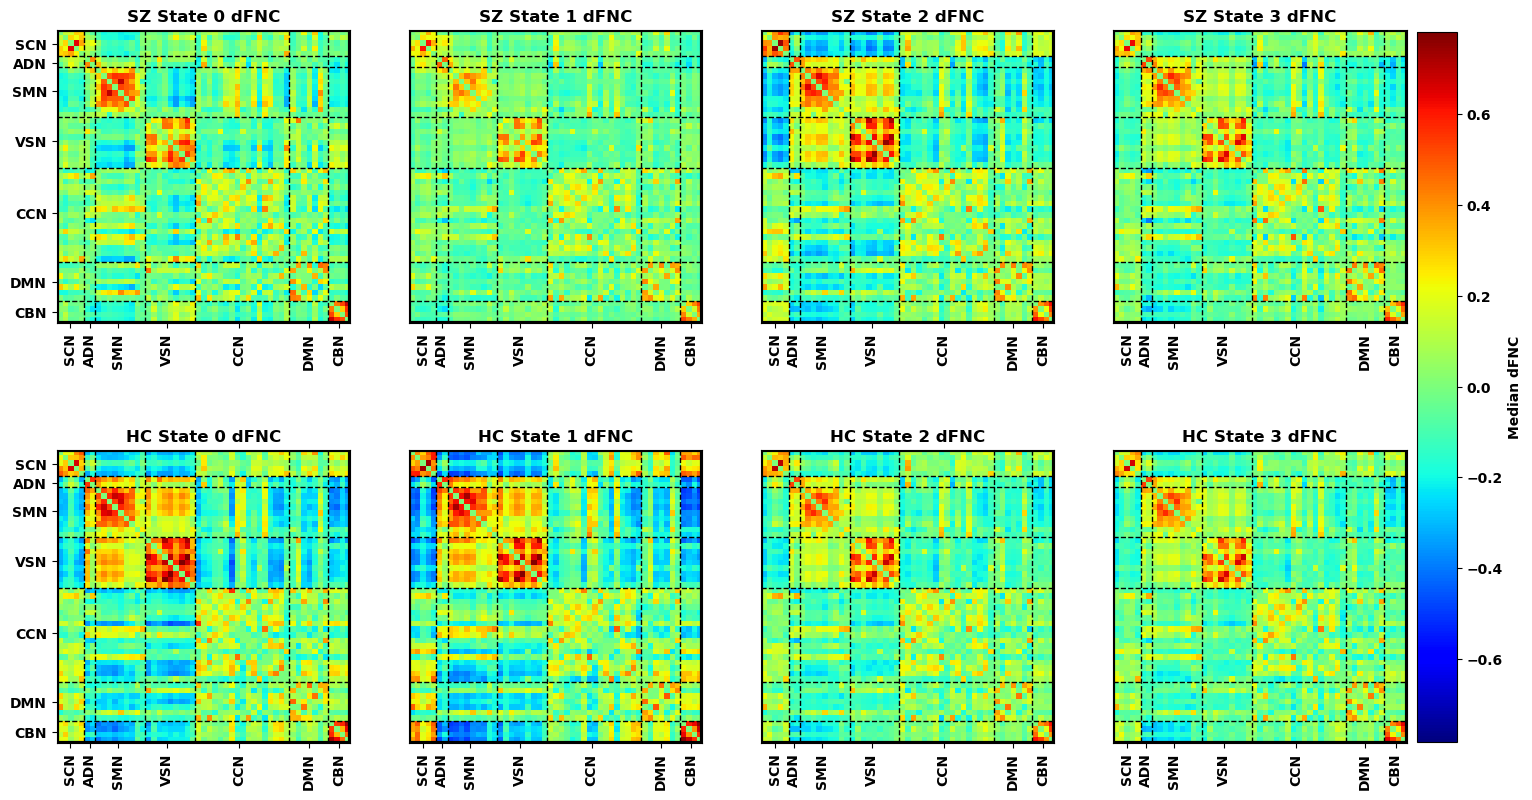

In [18]:
## Figure 6
# Make Heatmaps of dFNC
fig, ax = plt.subplots(2,4,figsize=(20,10))
i = 0

# Get Median dFNC 
s_vals = []
for class_idx in range(2):
    for state in range(4):
        class_condition = train_labels3==class_idx*np.ones_like(train_labels3)
        state_condition = cluster_labels == state*(np.ones_like(cluster_labels))                                        
        s_vals.append(np.median(X3[np.logical_and(class_condition,state_condition),...],axis=0))

        
max_val = np.max(np.abs(s_vals)) # Get Max Heatmap Bounds from Median dFNC
min_val = -1*max_val
class_val = ['SZ','HC']
for class_idx in range(2):
    for state in range(4):
        class_condition = train_labels3==class_idx*np.ones_like(train_labels3)
        state_condition = cluster_labels == state*(np.ones_like(cluster_labels))                                        
        s_vals = np.median(X3[np.logical_and(class_condition,state_condition),...],axis=0)
        im = ax[class_idx,state].imshow(vec2mat(s_vals,53), cmap = 'jet', vmin = min_val, vmax = max_val)
        ax[class_idx,state].set_xticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
        ax[class_idx,state].set_xticklabels(networks,rotation=90,weight='bold')
        ax[class_idx,state].set_title(f'{class_val[class_idx]} State {state} dFNC',weight='bold')
        if state == 0:
            ax[class_idx,state].set_yticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
            ax[class_idx,state].set_yticklabels(networks,weight='bold')
        else:
            ax[class_idx,state].set_yticks([])
        ax[class_idx,state].vlines([4.5,6.5,15.5,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=1)
        ax[class_idx,state].hlines([4.25,6.25,15.25,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=1)
        ax[class_idx,state].vlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=3)
        ax[class_idx,state].hlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=3)
        i += 1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.14, 0.02, 0.71]) # left bottom width height
cb = fig.colorbar(im, cax=cbar_ax);
cb.set_label(label='Median dFNC',weight='bold')
plt.setp(cb.ax.get_yticklabels(),weight='bold');
# plt.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/Journal/Results/Figure6 - MediandFNCPerStateClass.jpg",dpi=1200)

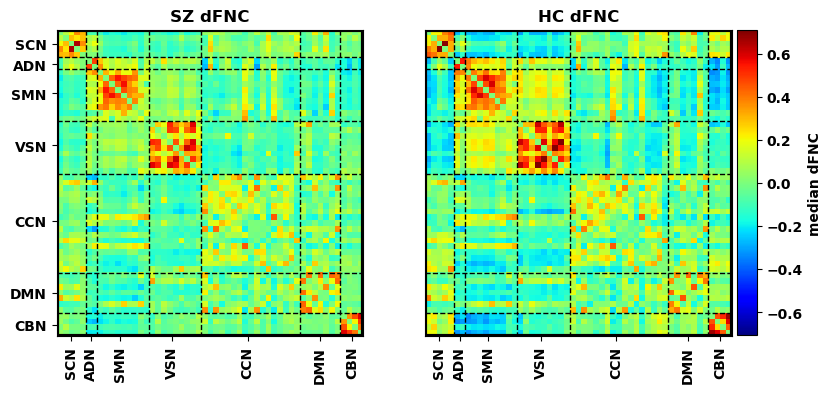

In [19]:
## FIGURE 3a
# Make Heatmaps of dFNC for Each Class - update size
fig, ax = plt.subplots(1,2,figsize=(10,5))
i = 0

s_vals = []
for class_idx in range(2):
        class_condition = train_labels3==class_idx*np.ones_like(train_labels3)
        s_vals.append(np.median(X3[class_condition,...],axis=0))

        
max_val = np.max(np.abs(s_vals))
min_val = -1*max_val
class_val = ['SZ','HC']
for class_idx in range(2):
    class_condition = train_labels3==class_idx*np.ones_like(train_labels3)
    s_vals = np.median(X3[class_condition,...],axis=0)
    im = ax[class_idx].imshow(vec2mat(s_vals,53), cmap = 'jet', vmin = min_val, vmax = max_val)
    ax[class_idx].set_xticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
    ax[class_idx].set_xticklabels(networks,rotation=90,weight='bold')
    ax[class_idx].set_title(f'{class_val[class_idx]} dFNC',weight='bold')
    if class_idx == 0:
        ax[class_idx].set_yticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
        ax[class_idx].set_yticklabels(networks,weight='bold')
    else:
        ax[class_idx].set_yticks([])
    ax[class_idx].vlines([4.5,6.5,15.5,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=1)
    ax[class_idx].hlines([4.25,6.25,15.25,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=1)
    ax[class_idx].vlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=3)
    ax[class_idx].hlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=3)
    i += 1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.19, 0.02, 0.61]) # left bottom width height
cb = fig.colorbar(im, cax=cbar_ax);
cb.set_label(label='median dFNC',weight='bold')
plt.setp(cb.ax.get_yticklabels(),weight='bold');
# plt.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/Journal/Results/Figure3a - dFNCperClass.jpg",dpi=1200)

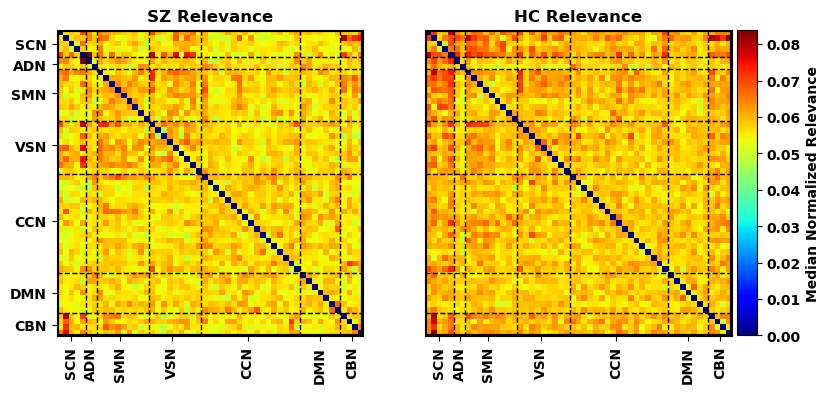

In [20]:
## Figure 3b
# Make Heatmaps of LRP for Each Class
fig, ax = plt.subplots(1,2,figsize=(10,5))
i = 0

s_vals = []
for class_idx in range(2):
        class_condition = train_labels3==class_idx*np.ones_like(train_labels3)
        s_vals.append(100*np.median(lrp_val3[class_condition,...],axis=0))

        
max_val = np.max(np.abs(s_vals))
min_val = 0
class_val = ['SZ','HC']
for class_idx in range(2):
    class_condition = train_labels3==class_idx*np.ones_like(train_labels3)
    s_vals = 100*np.median(lrp_val3[class_condition,...],axis=0)
    im = ax[class_idx].imshow(vec2mat(s_vals,53), cmap = 'jet', vmin = min_val, vmax = max_val)
    ax[class_idx].set_xticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
    ax[class_idx].set_xticklabels(networks,rotation=90,weight='bold')
    ax[class_idx].set_title(f'{class_val[class_idx]} Relevance',weight='bold')
    if class_idx == 0:
        ax[class_idx].set_yticks([2,5.5,10.5,19.5,32.5,45,50.5],thickness=5)
        ax[class_idx].set_yticklabels(networks,weight='bold')
    else:
        ax[class_idx].set_yticks([])
    ax[class_idx].vlines([4.5,6.5,15.5,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=1)
    ax[class_idx].hlines([4.25,6.25,15.25,24.5,41.5,48.5],-0.5,52.5,'k','--',linewidth=1)
    ax[class_idx].vlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=3)
    ax[class_idx].hlines([-0.5,52.5],-0.5,52.5,'k','-',linewidth=3)
    i += 1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.19, 0.02, 0.61]) # left bottom width height
cb = fig.colorbar(im, cax=cbar_ax);
cb.set_label(label='Median Normalized Relevance',weight='bold')
plt.setp(cb.ax.get_yticklabels(),weight='bold');
# plt.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/Journal/Results/Figure3b - RelevanceperClass.jpg",dpi=1200)

In [15]:
# Convert Array of Features in Format for Classification to Connectivity Matrix Format
def vec2mat(vec,ROI):
    matrix = np.zeros((ROI,ROI))
    #     matrix = np.chararray((ROI,ROI),itemsize=13) # if string
    count = 0
    for i in np.arange(ROI):
        for j in np.arange(i+1,ROI):
            matrix[i,j] = vec[count]
            matrix[j,i] = vec[count]
            count += 1
    return(matrix)

# Calculate Dynamical Features

In [21]:
# OCR
ocr_vals = [];
for i in np.unique(train_subj3):
    s_vals = np.array(cluster_labels)[np.squeeze(i*np.ones_like(train_subj3)==train_subj3)]
    
    values, counts = np.unique(s_vals,return_counts=True)
    
    # Make sure that if subject doesn't have a sample in a particular cluster, the missing cluster has a count of 0
    counts2 = np.zeros((top_clust,1))
    for j in range(len(values)):
        counts2[values[j]] = counts[j]
    
    ocr_vals.append(np.squeeze(counts2/(np.sum(counts2)*np.ones_like(counts2)))) # calculate OCR values

In [22]:
# Number of State Transitions

nst_vals = [];
# cluster_labels = kmeans.labels_
for i in np.unique(train_subj3):
    s_vals = np.array(cluster_labels)[np.squeeze(i*np.ones_like(train_subj3)==train_subj3)] # get cluster assignments for subject i
    nst_vals.append(np.sum(np.diff(s_vals)>np.zeros((len(s_vals)-1)))) # calculate OCR values

In [23]:
features = np.concatenate((np.expand_dims(nst_vals,axis=1),ocr_vals),axis=1)
feature_names = ['NST','OCR 0', 'OCR 1', 'OCR 2', 'OCR 3', 'OCR 4']

# Perform Class-Level Statistical Testing and Visually Compare Features



In [24]:
from scipy.stats import ttest_ind
# Test for Significant Differences Between Features for SZs and HCs
p_vals_corrected = np.ones((1,5))
t_stat = []; p_vals = []
for feature_idx in range(np.shape(features)[1]):
    feature = features[:,feature_idx].copy()
    stat, p_val = ttest_ind(feature[np.squeeze(Y==np.ones_like((Y)))],feature[np.squeeze(Y==np.zeros_like((Y)))]) # HCs, SZs
    t_stat.append(stat); p_vals.append(p_val)
    print(feature_names[feature_idx])
    print('T-stat = ' + str(stat) + ' - P-Value = ' + str(p_val))
p_vals_corrected[0] = p_vals[0] # don't correct NST
p_vals_corrected[0,1:] = fdrcorrection(p_vals[1:])[1] # correct OCR p-values
print(list(np.round(p_vals_corrected,5)))

NST
T-stat = 3.0259651882536995 - P-Value = 0.0026867266494713608
OCR 0
T-stat = -6.261178546758098 - P-Value = 1.276638149484701e-09
OCR 1
T-stat = -3.764283053401878 - P-Value = 0.00019987906145228188
OCR 2
T-stat = 6.381401038972187 - P-Value = 6.410177647300126e-10
OCR 3
T-stat = 4.63847207516877 - P-Value = 5.189663965471063e-06
[array([2.69e-03, 0.00e+00, 2.00e-04, 0.00e+00, 1.00e-05])]


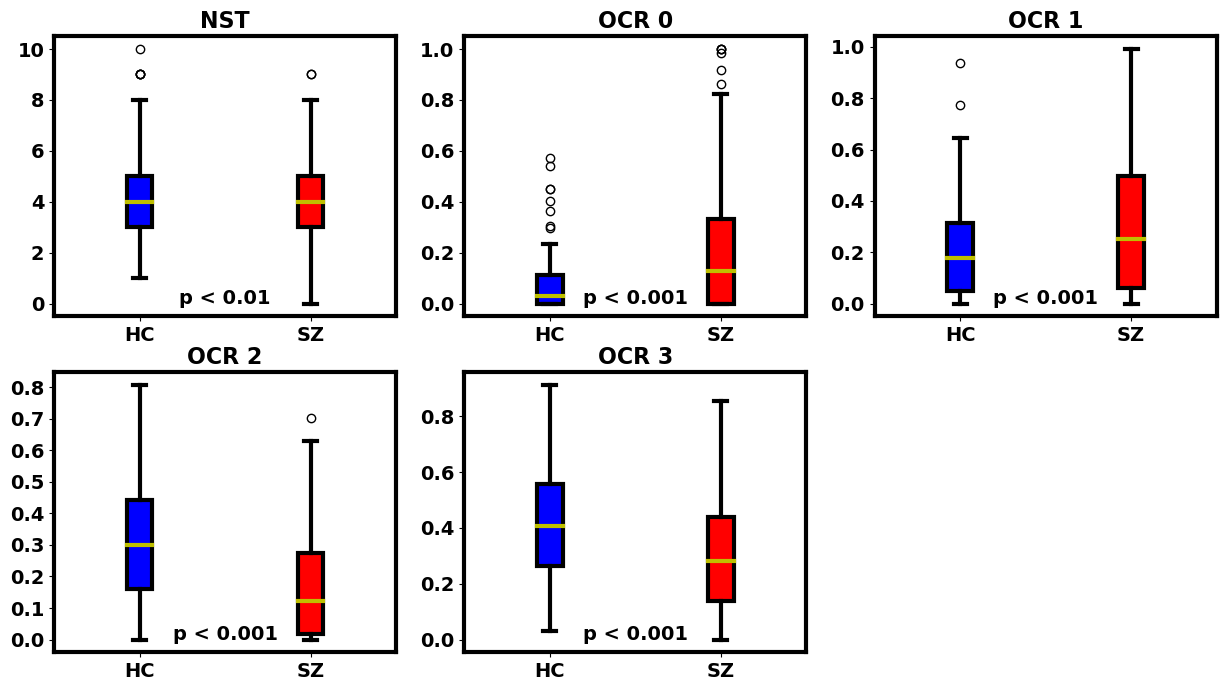

In [25]:
## FIGURE 7
plt.figure(figsize=(15,8))
for feature_idx in np.arange(5):
    feature = features[:,feature_idx].copy()
    ax = plt.subplot(2,3,feature_idx+1)
    bplot_hc = plt.boxplot(feature[np.squeeze(Y==np.ones_like((Y)))],positions=[1],patch_artist=True) # HCs
    bplot_sz = plt.boxplot(feature[np.squeeze(Y==np.zeros_like((Y)))],positions=[2],patch_artist=True) # SZs
    plt.title(feature_names[feature_idx],weight='bold',fontsize=16)
    plt.xticks([1,2],['HC','SZ'],weight='bold',fontsize=14)
    plt.yticks(weight='bold',fontsize=14)
    
    if np.array(p_vals_corrected)[0,feature_idx] < 0.001:
        plt.text(1.5,0,'p < 0.001',horizontalalignment='center',fontsize=14,weight='bold')
    elif np.array(p_vals_corrected)[0,feature_idx] < 0.01:
        plt.text(1.5,0,'p < 0.01',horizontalalignment='center',fontsize=14,weight='bold')
    
    # Set Face color
    colors = ['blue','red']
    count=0
    for bplot in (bplot_hc,bplot_sz):
        # Set Whisker Color
        for whisker in bplot['whiskers']:
            whisker.set(color='k',linewidth=3)
        # Set Caps Color
        for cap in bplot['caps']:
            cap.set(color='k',linewidth=3)
        # Set Box Outline Color
        for box in bplot['boxes']:
            box.set(color='k',linewidth=3)
        # Set Median Color
        for med in bplot['medians']:
            med.set(color='y',linewidth=3)
        # Set Face Color
        for patch, color in zip(bplot['boxes'],colors[count]):
            patch.set_facecolor(color)
            count+=1
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
# plt.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/Journal/Results/Figure7 - State_Related_Features.jpg",dpi=1200)

## Analyze Relationships between Subtypes and Scores

In [31]:
## IMPORT DATA

datadir1 = "C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/"
datadir2 = "C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/"
filename1 = "sz_lrp_cluster_labels2.mat"
filename2 = "clinical_scores.mat"

cluster_labels = loadmat(os.path.join(datadir1,filename1))['cluster_labels']
cluster_subj_ids = np.squeeze(loadmat(os.path.join(datadir1,filename1))['train_subj3'])
score_names = loadmat(os.path.join(datadir2,filename2))['FILE_ID']
scores = loadmat(os.path.join(datadir2,filename2))['analysis_SCORE']
subj_idx = np.arange(np.shape(scores)[0])

In [32]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [33]:
# Get Columns of Interest
columns = np.arange(14)
columns = np.delete(columns,3) # don't include site
columns = np.delete(columns,2) # don't include diagnosis
columns = np.delete(columns,1) # don't include gender
columns = np.delete(columns,0) # don't include age

# Train Regression with Individual Scores as Independent Variable and Features as Dependent Variable
p_values = np.ones((np.shape(features)[1],len(columns)))
t_values = np.ones((np.shape(features)[1],len(columns)))

for feature_idx in range(np.shape(features)[1]):
    for score_idx in (4,5):#columns:
        scores_to_include = np.zeros((14,));
        scores_to_include[0] += 1; # include age
        scores_to_include[1] += 1; # include gender
        scores_to_include[score_idx] += 1; # include score of interest
        
#         print(np.squeeze(scores_to_include.astype(int)))
        if score_idx in (4,5):
            s1_vals = scores[np.squeeze(Y==np.zeros_like((Y))),:] # get scores for SZs
            s1_vals = s1_vals[:,np.array(scores_to_include.astype(int),dtype=bool)]
            feature_vals = features[np.squeeze(Y==np.zeros_like((Y))),feature_idx] # get state features
        else:
            s1_vals = scores.copy()
            s1_vals = s1_vals[:,np.array(scores_to_include.astype(int),dtype=bool)]
            feature_vals = features[:,feature_idx] # get state features
        
        feature_vals = feature_vals[np.sum(np.squeeze(s1_vals==-9999*np.ones_like(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0])]
        s1_vals = s1_vals[np.sum(np.squeeze(s1_vals==-9999*np.ones_like(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0]),:]
        feature_vals = feature_vals[np.sum(np.squeeze(np.isnan(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0])] # remove samples with NaN scores
        s1_vals = s1_vals[np.sum(np.squeeze(np.isnan(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0]),:]
        
        s1_vals = sm.add_constant(s1_vals)
        results = OLS(feature_vals,s1_vals).fit()
        p_values[feature_idx,score_idx-4] = results.pvalues[3]
        t_values[feature_idx,score_idx-4] = results.tvalues[3]

        if p_values[feature_idx,score_idx-4] < 0.05:
            print('\033[1m' + feature_names[feature_idx] + ' vs ' + score_names[0][score_idx].item() + '\033[0m')
            print('\033[1m' + 'T-stat = ' + str(t_values[feature_idx,score_idx-4]) + ' - P-Value = ' + str(p_values[feature_idx,score_idx-4]) + '\033[0m')
        else:
            print(feature_names[feature_idx] + ' vs ' + score_names[0][score_idx].item())
            print('T-stat = ' + str(t_values[feature_idx,score_idx-4]) + ' - P-Value = ' + str(p_values[feature_idx,score_idx-4]))

NST vs PANSS(positive)
T-stat = 0.6804854496163582 - P-Value = 0.49732096633757783
NST vs PANSS(negative)
T-stat = -0.18220182267453472 - P-Value = 0.8556879022154806
OCR 0 vs PANSS(positive)
T-stat = -0.031048057931432588 - P-Value = 0.9752754319361552
OCR 0 vs PANSS(negative)
T-stat = -1.1902854914552417 - P-Value = 0.23594864236442448
OCR 1 vs PANSS(positive)
T-stat = -1.3352640278852144 - P-Value = 0.18395697291951812
OCR 1 vs PANSS(negative)
T-stat = 1.3043627146928483 - P-Value = 0.19425022951043894
OCR 2 vs PANSS(positive)
T-stat = 0.8116993367186931 - P-Value = 0.41834209688082546
OCR 2 vs PANSS(negative)
T-stat = 0.31376500459922113 - P-Value = 0.7541665463870267
OCR 3 vs PANSS(positive)
T-stat = 0.9566445023915608 - P-Value = 0.34039575328249727
OCR 3 vs PANSS(negative)
T-stat = -0.27973779638819657 - P-Value = 0.7800915512415016


# Output Relevance Temporal Distribution for Each Subtype

In [25]:
from scipy.stats import entropy

In [136]:
group_names[5]

'SMN    '

In [26]:
#LRP Alpha-Beta Rule Implementation
def LRP_Output_ab_temporal(model,data,class_labels,groups):
    #Strip softmax layer
    model_lrp = innvestigate.utils.model_wo_softmax(model)

    analyzer = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model_lrp,neuron_selection_mode="index")

    for j in range(np.shape(data)[0]): # iterate over each sample
        x = data[j,:,:]
        a = analyzer.analyze(x[None], neuron_selection = class_labels[j])
        
        # EMD - Examines How Temporally Concentrated Relevance Distribution is Within Each Domain Pair
        a1 = [];
        for group in np.unique(groups):
            group_idx = np.squeeze(groups==group*np.ones_like(groups))
            a1.append(wasserstein_distance(np.squeeze(100*np.nansum(np.abs(a[:,:,group_idx]),axis=2)/np.nansum(np.abs(a[:,:,group_idx]))),np.squeeze(100*np.ones(np.shape(a)[1])/np.shape(a)[1])))
        
        # EMD - Examines How Temporally Concentrated Total Relevance Distribution is Across All Features
        a2 = wasserstein_distance(np.squeeze(100*np.nansum(np.abs(a),axis=2)/np.nansum(np.abs(a))),np.squeeze(100*np.ones(np.shape(a)[1])/np.shape(a)[1])) 
        
        # Entropy - Examines How Relevance Distribution Shifts Between Nodes at Each Time Step
        a3 = entropy(np.abs(a[0,...]).T/np.sum(np.abs(a[0,...]),axis=1))

        a_range = np.ptp(a3) # get range
        a_sd = np.std(a3) # get SD
        a_mean = np.mean(a3) # get average
        a_median = np.median(a3) # get average
        a_max = np.max(a3) # get max
            
        if j == 0:
            # EMD
            Rel_out = np.array(a2)[None]
            
            # EMD - Domain Pair-Level
            EMD_pair = np.array(a1)[None]
            
            # KLD
            Rel_range = np.array(a_range)[None]
            Rel_sd = np.array(a_sd)[None]
            Rel_mean = np.array(a_mean)[None]
            Rel_median = np.array(a_median)[None]
            Rel_max = np.array(a_max)[None]
        else:
            # EMD
            Rel_out = np.vstack((Rel_out,np.array(a2)[None]))
            
            # EMD - Domain Pair-Level
            EMD_pair = np.vstack((EMD_pair,np.array(a1)[None]))
            
            # KLD
            Rel_range = np.vstack((Rel_range,np.array(a_range)[None]))
            Rel_sd = np.vstack((Rel_sd,np.array(a_sd)[None]))
            Rel_mean = np.vstack((Rel_mean,np.array(a_mean)[None]))
            Rel_median = np.vstack((Rel_median,np.array(a_median)[None]))
            Rel_max = np.vstack((Rel_max,np.array(a_max)[None]))
    return(Rel_out,EMD_pair,Rel_range,Rel_sd,Rel_mean,Rel_median,Rel_max)

In [216]:
n_folds = 10
count = 0
train_labels = []; train_subj = []; lrp_val_emd = []; lrp_val_emd_domain_pair = [];
lrp_val_kl_range = []; lrp_val_kl_sd = []; lrp_val_kl_mean = []; lrp_val_kl_median = []; lrp_val_kl_max = [];
cv = StratifiedShuffleSplit(n_splits=n_folds,test_size=0.1,train_size=0.9,random_state=0)#0
for train_val_idx, test_idx in cv.split(X,Y):
    X_train_val = X[train_val_idx,...]
    Y_train_val = Y[train_val_idx,...]
    S_train_val = S[train_val_idx,...]
    # Split Train/Val Data into Training and Validation Groups
    cv2 = StratifiedShuffleSplit(n_splits=1,test_size=0.11,train_size=0.89,random_state=0)#0
    for train_idx, val_idx in cv2.split(X_train_val,Y_train_val):
        X_train = X_train_val[train_idx,...]
        Y_train = Y_train_val[train_idx,...]
        S_train = S_train_val[train_idx,...]
    X_train_val = []; Y_train_val = []; S_train_val = []
    
    model2 = get_model()
    model2.load_weights("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/cnn_model2_FBIRN_Fold"+str(count)+".hdf5")
    
    train_labels.append(Y_train)
    train_subj.append(S_train)

    vals = LRP_Output_ab_temporal(model2,X_train,Y_train,groups)
    
    lrp_val_emd.append(vals[0])
    lrp_val_emd_domain_pair.append(vals[1])
    lrp_val_kl_range.append(vals[2])
    lrp_val_kl_sd.append(vals[3])
    lrp_val_kl_mean.append(vals[4])
    lrp_val_kl_median.append(vals[5])
    lrp_val_kl_max.append(vals[6])
    
    print(count)
    count += 1
    
train_subj = np.array(train_subj)
train_labels = np.array(train_labels)

lrp_val_emd = np.array(lrp_val_emd)
lrp_val_emd_domain_pair = np.array(lrp_val_emd_domain_pair)
lrp_val_kl_range = np.array(lrp_val_kl_range)
lrp_val_kl_sd = np.array(lrp_val_kl_sd)
lrp_val_kl_mean = np.array(lrp_val_kl_mean)
lrp_val_kl_median = np.array(lrp_val_kl_median)
lrp_val_kl_max = np.array(lrp_val_kl_max)

(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1

(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1

(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1

(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1

C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1

(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1378)
(1, 124, 1

In [217]:
# Reshape Relevance Features for Averaging
train_subj2 = []; train_labels2 = []
lrp_val_emd2 = []; lrp_val_emd_domain_pair2 = []; 
lrp_val_kl_range2 = []; lrp_val_kl_sd2 = []; lrp_val_kl_mean2 = []; lrp_val_kl_median2 = []; lrp_val_kl_max2 = [];

for i in range(n_folds):
    lrp_val_emd2.extend(lrp_val_emd[i,...])
    lrp_val_emd_domain_pair2.extend(lrp_val_emd_domain_pair[i,...])
    
    lrp_val_kl_range2.extend(lrp_val_kl_range[i,...])
    lrp_val_kl_sd2.extend(lrp_val_kl_sd[i,...])
    lrp_val_kl_mean2.extend(lrp_val_kl_mean[i,...])
    lrp_val_kl_median2.extend(lrp_val_kl_median[i,...])
    lrp_val_kl_max2.extend(lrp_val_kl_max[i,...])
    
    train_subj2.extend(train_subj[i,...])
    train_labels2.extend(train_labels[i,...])
    
lrp_val_emd2 = np.array(lrp_val_emd2)
lrp_val_emd_domain_pair2 = np.array(lrp_val_emd_domain_pair2)
lrp_val_kl_range2 = np.array(lrp_val_kl_range2)
lrp_val_kl_sd2 = np.array(lrp_val_kl_sd2)
lrp_val_kl_mean2 = np.array(lrp_val_kl_mean2)
lrp_val_kl_median2 = np.array(lrp_val_kl_median2)
lrp_val_kl_max2 = np.array(lrp_val_kl_max2)

train_subj2 = np.array(train_subj2)
train_labels2 = np.array(train_labels2)

# Get Average Relevance Features for Each Participant Across Folds
train_subj3 = []; train_labels3 = [];
lrp_val_emd3 = []; lrp_val_emd_domain_pair3 = [];
lrp_val_kl_range3 = []; lrp_val_kl_sd3 = []; lrp_val_kl_mean3 = []; lrp_val_kl_median3 = []; lrp_val_kl_max3 = [];

for i in np.unique(train_subj2): # iterate over participants
    lrp_val_emd3.extend(np.nanmean(lrp_val_emd2[np.squeeze(train_subj2==i*np.ones_like(train_subj2)),...],axis=0)) # feature-wise average relevance for participant at iteration i
    lrp_val_emd_domain_pair3.append(np.nanmean(lrp_val_emd_domain_pair2[np.squeeze(train_subj2==i*np.ones_like(train_subj2)),...],axis=0)) # feature-wise average relevance for participant at iteration i
    lrp_val_kl_range3.extend(np.nanmean(lrp_val_kl_range2[np.squeeze(train_subj2==i*np.ones_like(train_subj2)),...],axis=0)) # feature-wise average relevance for participant at iteration i
    lrp_val_kl_sd3.extend(np.nanmean(lrp_val_kl_sd2[np.squeeze(train_subj2==i*np.ones_like(train_subj2)),...],axis=0)) # feature-wise average relevance for participant at iteration i
    lrp_val_kl_mean3.extend(np.nanmean(lrp_val_kl_mean2[np.squeeze(train_subj2==i*np.ones_like(train_subj2)),...],axis=0)) # feature-wise average relevance for participant at iteration i
    lrp_val_kl_median3.extend(np.nanmean(lrp_val_kl_median2[np.squeeze(train_subj2==i*np.ones_like(train_subj2)),...],axis=0)) # feature-wise mean relevance for participant at iteration i
    lrp_val_kl_max3.extend(np.nanmean(lrp_val_kl_max2[np.squeeze(train_subj2==i*np.ones_like(train_subj2)),...],axis=0)) # feature-wise average relevance for participant at iteration i
 
    train_subj3.extend(i*np.ones((124,)))
    train_labels3.extend(np.unique(train_labels2[np.squeeze(train_subj2==i*np.ones_like(train_subj2))])*np.ones((124,)))

    
lrp_val_emd3 = np.array(lrp_val_emd3)
lrp_val_emd_domain_pair3 = np.array(lrp_val_emd_domain_pair3)
lrp_val_kl_range3 = np.array(lrp_val_kl_range3)
lrp_val_kl_sd3 = np.array(lrp_val_kl_sd3)
lrp_val_kl_mean3 = np.array(lrp_val_kl_mean3)
lrp_val_kl_median3 = np.array(lrp_val_kl_median3)
lrp_val_kl_max3 = np.array(lrp_val_kl_max3)

train_subj3 = np.array(train_subj3)
train_labels3 = np.array(train_labels3)

In [218]:
features2 = np.concatenate((lrp_val_emd_domain_pair3,np.expand_dims(lrp_val_emd3,axis=1),np.expand_dims(lrp_val_kl_range3,axis=1),np.expand_dims(lrp_val_kl_sd3,axis=1),
                          np.expand_dims(lrp_val_kl_mean3,axis=1),np.expand_dims(lrp_val_kl_median3,axis=1),np.expand_dims(lrp_val_kl_max3,axis=1)),axis=1)

feature_names2 = ['Total EMD','KLD Range', 'KLD SD', 'KLD Median','KLD Mean', 'KLD Max']

feature_names3 = [];
for i in group_names:
    feature_names3.append(i + ' EMD')

for i in feature_names2:
    feature_names3.append(i)

In [219]:
from scipy.stats import ttest_ind
# Test for Significant Differences Between Features for SZs and HCs
p_vals_corrected = np.ones((1,34))
t_stat = []; p_vals = []
for feature_idx in range(np.shape(features2)[1]):
    feature = features2[:,feature_idx]
    stat, p_val = ttest_ind(feature[np.squeeze(Y==np.ones_like((Y)))],feature[np.squeeze(Y==np.zeros_like((Y)))]) # HCs - SZs, negative t-stat means SZ has higher value
#     p_val = mannwhitneyu(feature[np.squeeze(Y==np.ones_like((Y)))],feature[np.squeeze(Y==np.zeros_like((Y)))])[1] # HCs - SZs, negative t-stat means SZ has higher value
    p_vals.append(p_val); t_stat.append(stat); 
    
p_vals_corrected[0,:] = p_vals[:]
p_vals_corrected[0,:28] = fdrcorrection(p_vals[:28])[1]
p_vals_corrected[0,29:] = fdrcorrection(p_vals[29:])[1]

for feature_idx in range(np.shape(features2)[1]):
    print(feature_names3[feature_idx])
    print('T-stat = ' + str(t_stat[feature_idx]) + ' - P-Value = ' + str(p_vals_corrected[0,feature_idx]))
#     print('P-Value = ' + str(p_vals_corrected[0,feature_idx]))

SCN     EMD
T-stat = 0.8748027239850159 - P-Value = 0.9986725809254834
ADN/SCN EMD
T-stat = -0.19467568882260003 - P-Value = 0.9986725809254834
ADN     EMD
T-stat = -2.331401465944981 - P-Value = 0.5704981453001807
SMN/SCN EMD
T-stat = 1.3454107461396858 - P-Value = 0.9986725809254834
SMN/ADN EMD
T-stat = 0.2155575561055512 - P-Value = 0.9986725809254834
SMN     EMD
T-stat = 0.25638935060011325 - P-Value = 0.9986725809254834
VSN/SCN EMD
T-stat = 0.23842761686107755 - P-Value = 0.9986725809254834
VSN/ADN EMD
T-stat = -0.23558926859908746 - P-Value = 0.9986725809254834
VSN/SMN EMD
T-stat = -0.33111713056530323 - P-Value = 0.9986725809254834
VSN     EMD
T-stat = -0.25718192552870073 - P-Value = 0.9986725809254834
CCN/SCN EMD
T-stat = 0.7039815810909542 - P-Value = 0.9986725809254834
CCN/ADN EMD
T-stat = -0.0016650204201721565 - P-Value = 0.9986725809254834
CCN/SMN EMD
T-stat = 0.35760723386122323 - P-Value = 0.9986725809254834
CCN/VSN EMD
T-stat = -0.00846831636968705 - P-Value = 0.998672

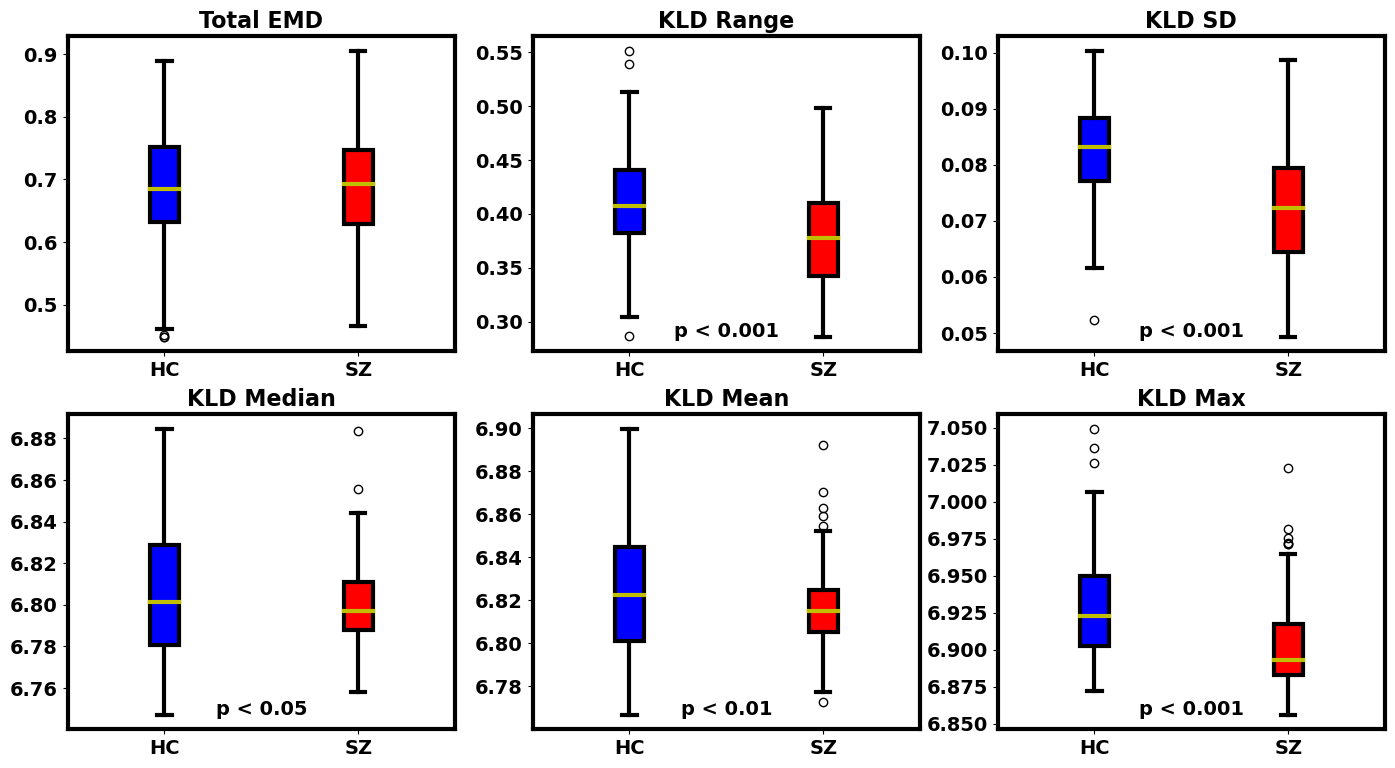

In [220]:
## FIGURE 8
plt.figure(figsize=(17,9))
for feature_idx in np.arange(28,34):
    feature = features2[:,feature_idx].copy()
    ax = plt.subplot(2,3,feature_idx-27)
    bplot_hc = plt.boxplot(feature[np.squeeze(Y==np.ones_like((Y)))],positions=[1],patch_artist=True) # HCs
    bplot_sz = plt.boxplot(feature[np.squeeze(Y==np.zeros_like((Y)))],positions=[2],patch_artist=True) # SZs
    plt.title(feature_names3[feature_idx],weight='bold',fontsize=16)
    plt.xticks([1,2],['HC','SZ'],weight='bold',fontsize=14)
    plt.yticks(weight='bold',fontsize=14)
    
    if np.array(p_vals_corrected)[0,feature_idx] < 0.001:
        plt.text(1.5,np.min(feature),'p < 0.001',horizontalalignment='center',fontsize=14,weight='bold')
    elif np.array(p_vals_corrected)[0,feature_idx] < 0.01:
        plt.text(1.5,np.min(feature),'p < 0.01',horizontalalignment='center',fontsize=14,weight='bold')
    elif np.array(p_vals_corrected)[0,feature_idx] < 0.05:
        plt.text(1.5,np.min(feature),'p < 0.05',horizontalalignment='center',fontsize=14,weight='bold')
    
    # Set Face color
    colors = ['blue','red']
    count=0
    for bplot in (bplot_hc,bplot_sz):
        # Set Whisker Color
        for whisker in bplot['whiskers']:
            whisker.set(color='k',linewidth=3)
        # Set Caps Color
        for cap in bplot['caps']:
            cap.set(color='k',linewidth=3)
        # Set Box Outline Color
        for box in bplot['boxes']:
            box.set(color='k',linewidth=3)
        # Set Median Color
        for med in bplot['medians']:
            med.set(color='y',linewidth=3)
        # Set Face Color
        for patch, color in zip(bplot['boxes'],colors[count]):
            patch.set_facecolor(color)
            count+=1
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
# plt.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/Relevance_Related/Journal/Results/Figure8_RelevanceDistributions.jpg",dpi=1200)

In [105]:
# Get Columns of Interest
columns = np.arange(14)
columns = np.delete(columns,3) # don't include site
columns = np.delete(columns,2) # don't include diagnosis
columns = np.delete(columns,1) # don't include gender
columns = np.delete(columns,0) # don't include age

# Train Regression with Individual Scores as Independent Variable and Features as Dependent Variable
p_values = np.ones((np.shape(features2)[1],len(columns)))
t_values = np.ones((np.shape(features2)[1],len(columns)))

for feature_idx in range(np.shape(features2)[1]):
    for score_idx in (4,5):#columns:
        scores_to_include = np.zeros((14,));
        scores_to_include[0] += 1; # include age
        scores_to_include[1] += 1; # include gender
        scores_to_include[score_idx] += 1; # include score of interest
        
        if score_idx in (4,5):
            s1_vals = scores[np.squeeze(Y==np.zeros_like((Y))),:] # get scores for SZs
            s1_vals = s1_vals[:,np.array(scores_to_include.astype(int),dtype=bool)]
            feature_vals = features2[np.squeeze(Y==np.zeros_like((Y))),feature_idx] # get state features
        else:
            s1_vals = scores.copy()
            s1_vals = s1_vals[:,np.array(scores_to_include.astype(int),dtype=bool)]
            feature_vals = features2[:,feature_idx] # get state features
        
        feature_vals = feature_vals[np.sum(np.squeeze(s1_vals==-9999*np.ones_like(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0])]
        s1_vals = s1_vals[np.sum(np.squeeze(s1_vals==-9999*np.ones_like(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0]),:]
        feature_vals = feature_vals[np.sum(np.squeeze(np.isnan(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0])] # remove samples with NaN scores
        s1_vals = s1_vals[np.sum(np.squeeze(np.isnan(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0]),:]
        
        s1_vals = sm.add_constant(s1_vals)
        results = OLS(feature_vals,s1_vals).fit()
        p_values[feature_idx,score_idx-4] = results.pvalues[3]
        t_values[feature_idx,score_idx-4] = results.tvalues[3]

        if p_values[feature_idx,score_idx-4] < 0.05:
            print('\033[1m' + feature_names3[feature_idx] + '\033[0m')
            print('\033[1m' + 'T-stat = ' + str(t_values[feature_idx,score_idx-4]) + ' - P-Value = ' + str(p_values[feature_idx,score_idx-4]) + '\033[0m')
        else:
            print(feature_names3[feature_idx])
            print('T-stat = ' + str(t_values[feature_idx,score_idx-4]) + ' - P-Value = ' + str(p_values[feature_idx,score_idx-4]))

SCN     EMD
T-stat = 0.5615128271033237 - P-Value = 0.5753457434309028
SCN     EMD
T-stat = -0.225311612216519 - P-Value = 0.8220654245256461
ADN/SCN EMD
T-stat = 0.1253226506521269 - P-Value = 0.9004479017944813
ADN/SCN EMD
T-stat = -0.3821374588068472 - P-Value = 0.7029388605920841
ADN     EMD
T-stat = -0.8865715924878668 - P-Value = 0.3768299969067469
ADN     EMD
T-stat = -0.8485845101068067 - P-Value = 0.3975611218962142
SMN/SCN EMD
T-stat = 0.9266394085741337 - P-Value = 0.3557084581453157
SMN/SCN EMD
T-stat = -0.4640679559229483 - P-Value = 0.6433198436843135
SMN/ADN EMD
T-stat = 0.11435954629970607 - P-Value = 0.9091166257300158
SMN/ADN EMD
T-stat = -0.840401576610045 - P-Value = 0.40211624805202806
SMN     EMD
T-stat = 0.0985715159035234 - P-Value = 0.9216194803493367
SMN     EMD
T-stat = -0.6834552040054777 - P-Value = 0.4954488165593368
VSN/SCN EMD
T-stat = 0.4522371600877892 - P-Value = 0.6517980754385471
VSN/SCN EMD
T-stat = -0.3265964538820343 - P-Value = 0.744460870923272